# Music recommender system

One of the most used machine learning algorithms is recommendation systems.  
  
A **recommender** (or recommendation) **system** (or engine) is a filtering system which aim is to predict a rating or preference a user would give to an item, eg. a film, a product, a song, etc.

## Importing required libraries

First, we'll import all the required libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split

## Reading the files

We are going to use the **[Million Song Dataset](http://millionsongdataset.com/)**, a freely-available collection of audio features and metadata for a million contemporary popular music tracks. 

There are two files that will be interesting for us. The first of them will give us information about the songs. Particularly, it contains the user ID, song ID and the listen count. On the other hand, the second file will contain song ID, title of that song, release, artist name and year. 
We need to merge these two DataFrames. For that aim, we'll use the `song_ID` 

In [3]:
#Read userid-songid-listen_count triplets
#This step might take time to download data from external sources
song_info_file = 'https://static.turi.com/datasets/millionsong/10000.txt'
songs_file = 'https://static.turi.com/datasets/millionsong/song_data.csv'

song_info = pd.read_csv(song_info_file,sep='\t',header=None)
song_info.columns = ['user_id', 'song_id', 'listen_count']

#Read song  metadata
song_actual =  pd.read_csv(songs_file)

#Merge the two dataframes above to create input dataframe for recommender systems
songs = pd.merge(song_info, song_actual.drop_duplicates(['song_id']), on="song_id", how="left")

In [4]:
songs = songs[:10000]

## Exploring the data

As usual, any data science or machine learning project starts with an exploratory data analysis (EDA). The aim of EDA is to understand and get insights on our data.

We'll first inspect the first rows of our `DataFrame`.

In [5]:
#Explore first rows
songs.head()

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


Then, we'll check how many observions there are in the dataset.

In [6]:
#Get total observations
print(f"There are {songs.shape[0]} observations in the dataset")

There are 10000 observations in the dataset


Now, we should perform some cleaning steps. But looking at the dataset, we can see that there is no missing values.

In [7]:
songs.isnull().sum()

user_id         0
song_id         0
listen_count    0
title           0
release         0
artist_name     0
year            0
dtype: int64

And most of the columns contain strings.

In [8]:
songs.dtypes

user_id         object
song_id         object
listen_count     int64
title           object
release         object
artist_name     object
year             int64
dtype: object

Let's start exploring some characteristics of the dataset: 

- Unique songs:

In [9]:
#Unique songs
print(f"There are {songs['title'].unique().shape[0]} unique songs in the dataset")

There are 5038 unique songs in the dataset


- Unique artists:

In [10]:
#Unique artists
print(f"There are {songs['artist_name'].unique().shape[0]} unique artists in the dataset")

There are 1994 unique artists in the dataset


- Unique users:

In [11]:
#Unique users
print(f"There are {songs['user_id'].unique().shape[0]} unique songs in the dataset")

There are 365 unique songs in the dataset


We'll go ahead and explore the popularity of songs and artists.

### Most popular songs

How do we determine which are the most popular songs? For this task, we'll count how many times each song appears. Note that while we are using  `listen_count`, we only care about the number of rows, we don't consider the number present in that row. This number represents how many times one user listen to the same song.

In [12]:
#count how many rows we have by song, we show only the ten more popular songs 
ten_pop_songs = songs.groupby('title')['listen_count'].count().reset_index().sort_values(['listen_count', 'title'], ascending = [0,1])
ten_pop_songs['percentage']  = round(ten_pop_songs['listen_count'].div(ten_pop_songs['listen_count'].sum())*100, 2)

In [13]:
ten_pop_songs[:10]

,title,listen_count,percentage
3576,Sehr kosmisch,45,0.45
4995,You're The One,36,0.36
4577,Undo,32,0.32
1044,Dog Days Are Over (Radio Edit),28,0.28
3571,Secrets,28,0.28
4282,The Scientist,27,0.27
4611,Use Somebody,27,0.27
3399,Revelry,26,0.26
1355,Fireflies,24,0.24
1811,Horn Concerto No. 4 in E flat K495: II. Romanc...,23,0.23


In [ ]:
plt.figure()
labels = ten_pop_songs['title'].tolist()
counts = ten_pop_songs['listen_count'].tolist()
sns.barplot(x=counts, y=labels, palette='Set3')
sns.despine(left=True, bottom=True)

### Most popular artist

For the next task, we'll count how many times each artist appears. Again, we'll count how many times the same artist appears.

In [ ]:
#count how many rows we have by artist name, we show only the ten more popular artist 
ten_pop_artists  = songs.groupby(['artist_name'])['listen_count'].count().reset_index().sort_values(['listen_count', 'artist_name'], 
                                                                                                ascending = [0,1])

In [ ]:
ten_pop_artists[:10]

In [ ]:
plt.figure()
labels = ten_pop_artists['artist_name'].tolist()
counts = ten_pop_artists['listen_count'].tolist()
sns.barplot(x=counts, y=labels, palette='Set2')
sns.despine(left=True, bottom=True)

### Listen count by user

We can also get some other information from the feature `listen_count`. We will answer the folloging questions:

**How many times on average the same user listen to a same song?**

In [18]:
print(f"On average, a user listen to the same song {songs['listen_count'].mean()} times")

On average, a user listen to the same song 2.9911 times


We can also check the distribution of `listen_count`:

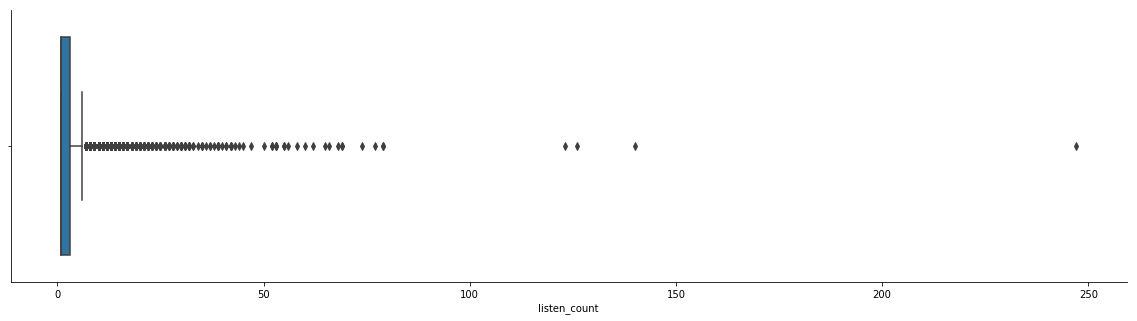

In [19]:
plt.figure(figsize=(20, 5))
sns.boxplot(x='listen_count', data=songs)
sns.despine()

**What was the maximum times the same user listen to a same song?**

In [20]:
print(f"The maximum times the same user listened to the same songs was as follows:")
songs.sort_values('listen_count', ascending=False)[['title',  'listen_count']][:10]

The maximum times the same user listened to the same songs was as follows:


,title,listen_count
7520,Waiting For A Dream,247
3616,Times,140
1639,Fools,126
9637,You're The One,123
9645,Catch You Baby (Steve Pitron & Max Sanna Radio...,79
5347,You're The One,79
2000,I C Love Affair,77
9643,El Cuatrero,74
2821,Undo,69
8073,How Am I Supposed To Live Without You,69


So, we know that we want to predict songs. So, in order to have all the information in only one column, we'll concatenate the song `title` with the `artist_name`. We'll assign the resultant string to the new column `song`.

In [21]:
#Concatenate title and artist name. Assign it to new columns
songs['song'] = songs['title'] + "-" + songs["artist_name"]

## Recommender systems

First of all, we need to define the recommerders. Which type of recommender can we have?   

There are two main types of recommender systems: 
- Content-based filters
- Collaborative filters
  
Content-based filters predicts what a user likes based on what that particular user has liked in the past. On the other hand, collaborative-based filters predict what a user like based on what other users, that are similar to that particular user, have liked. Among collaborative-based systems, we can encounter two types: **user-item** filtering and **item-item** filtering. 
  
We'll go through the steps for generating a item-item filtering music recommender system.

For this aim, we will first build a class called `item_similarity_recommender`. 

In [22]:
#Class for Item similarity based Recommender System model
class item_similarity_recommender():
    
    def __init__(self):
        self.train_data = None
        self.user_id = None
        self.item_id = None
        self.cooccurence_matrix = None
        self.songs_dict = None
        self.rev_songs_dict = None
        self.item_similarity_recommendations = None
        
    #Get unique items corresponding to a given user
    def get_user_items(self, user):
        user_data = self.train_data[self.train_data[self.user_id] == user]
        user_items = list(user_data[self.item_id].unique()) 
        return user_items
        
    #Get unique users for a given item
    def get_item_users(self, item):
        item_data = self.train_data[self.train_data[self.item_id] == item]
        item_users = set(item_data[self.user_id].unique())
        return item_users
        
    #Get unique items in the training data
    def get_all_items_train_data(self):
        all_items = list(self.train_data[self.item_id].unique())
        return all_items
        
    #Construct cooccurence matrix
    def construct_cooccurence_matrix(self, user_songs, all_songs):
        #Get users for all songs in user_songs.
        user_songs_users = []        
        for i in range(0, len(user_songs)):
            user_songs_users.append(self.get_item_users(user_songs[i]))

        cooccurence_matrix = np.matrix(np.zeros(shape=(len(user_songs), len(all_songs))), float)

        for i in range(0,len(all_songs)):
            #Calculate unique listeners (users) of song (item) i
            songs_i_data = self.train_data[self.train_data[self.item_id] == all_songs[i]]
            users_i = set(songs_i_data[self.user_id].unique())
            
            for j in range(0,len(user_songs)):       
                    
                #Get unique listeners (users) of song (item) j
                users_j = user_songs_users[j]
                    
                #Calculate intersection of listeners of songs i and j
                users_intersection = users_i.intersection(users_j)
                
                #Calculate cooccurence_matrix[i,j] as Jaccard Index
                if len(users_intersection) != 0:
                    #Calculate union of listeners of songs i and j
                    users_union = users_i.union(users_j)
                    
                    cooccurence_matrix[j,i] = float(len(users_intersection))/float(len(users_union))
                else:
                    cooccurence_matrix[j,i] = 0
                    
        
        return cooccurence_matrix

    
    #Use the cooccurence matrix to make top recommendations
    def generate_top_recommendations(self, user, cooccurence_matrix, all_songs, user_songs):
        print("Non zero values in cooccurence_matrix :%d" % np.count_nonzero(cooccurence_matrix))
        
        #Calculate a weighted average of the scores in cooccurence matrix for all user songs.
        user_sim_scores = cooccurence_matrix.sum(axis=0)/float(cooccurence_matrix.shape[0])
        user_sim_scores = np.array(user_sim_scores)[0].tolist()
 
        #Sort the indices of user_sim_scores based upon their value
        #Also maintain the corresponding score
        sort_index = sorted(((e,i) for i,e in enumerate(list(user_sim_scores))), reverse=True)
    
        #Create a dataframe from the following
        columns = ['user_id', 'song', 'score', 'rank']
        #index = np.arange(1) # array of numbers for the number of samples
        df = pd.DataFrame(columns=columns)
         
        #Fill the dataframe with top 10 item based recommendations
        rank = 1 
        for i in range(0,len(sort_index)):
            if ~np.isnan(sort_index[i][0]) and all_songs[sort_index[i][1]] not in user_songs and rank <= 10:
                df.loc[len(df)]=[user,all_songs[sort_index[i][1]],sort_index[i][0],rank]
                rank = rank+1
        
        #Handle the case where there are no recommendations
        if df.shape[0] == 0:
            print("The current user has no songs for training the item similarity based recommendation model.")
            return -1
        else:
            return df
 
    #Create the item similarity based recommender system model
    def create(self, train_data, user_id, item_id):
        self.train_data = train_data
        self.user_id = user_id
        self.item_id = item_id

    #Use the item similarity based recommender system model to
    #make recommendations
    def recommend(self, user):
        
        user_songs = self.get_user_items(user)    
            
        print("No. of unique songs for the user: %d" % len(user_songs))
        
        all_songs = self.get_all_items_train_data()
        
        print("no. of unique songs in the training set: %d" % len(all_songs))
         
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)
        
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)
                
        return df_recommendations
    
    #Get similar items to given items
    def get_similar_items(self, item_list):
        
        user_songs = item_list
        
        all_songs = self.get_all_items_train_data()
        
        print("no. of unique songs in the training set: %d" % len(all_songs))
         
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)

        user = ""
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)
         
        return df_recommendations

In [23]:
train_data, test_data = train_test_split(songs, test_size = 0.20, random_state=42)

In [24]:
is_model = item_similarity_recommender()
is_model.create(train_data, 'user_id', 'song')

In [25]:
users = songs['user_id'].unique()

In [26]:
user_id = users[5]
user_items = is_model.get_user_items(user_id)

In [27]:
for user_item in user_items:
    print(user_item)

Forgive Me-Leona Lewis
Speechless-Lady GaGa
Ya Nada Queda-Kudai
16 Candles-The Crests
Somebody To Love-Justin Bieber
Push It-Salt-N-Pepa
Say My Name-Destiny's Child
Just Lose It-Eminem
Without Me-Eminem
Missing You-John Waite
My Dad's Gone Crazy-Eminem / Hailie Jade


In [28]:
is_model.recommend(user_id)

No. of unique songs for the user: 11
no. of unique songs in the training set: 4528
Non zero values in cooccurence_matrix :1227


,user_id,song,score,rank
0,4bd88bfb25263a75bbdd467e74018f4ae570e5df,One Sweet Day-Mariah Carey feat. Boyz II Men,0.063636,1
1,4bd88bfb25263a75bbdd467e74018f4ae570e5df,U Smile-Justin Bieber,0.061983,2
2,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Teach Me How To Dougie-California Swag District,0.060147,3
3,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Hellbound-J-Black & Masta Ace,0.058442,4
4,4bd88bfb25263a75bbdd467e74018f4ae570e5df,You Found Me (Album Version)-The Fray,0.058442,5
5,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Mockingbird-Eminem,0.057966,6
6,4bd88bfb25263a75bbdd467e74018f4ae570e5df,The Real Slim Shady-Eminem,0.057910,7
7,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Terre Promise-O'Rosko Raricim,0.056818,8
8,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Shots-LMFAO / Lil Jon,0.055556,9
9,4bd88bfb25263a75bbdd467e74018f4ae570e5df,I'm On A Boat-The Lonely Island / T-Pain,0.053535,10


In [29]:
is_model.get_similar_items(['U Smile - Justin Bieber'])

no. of unique songs in the training set: 4528
Non zero values in cooccurence_matrix :0


,user_id,song,score,rank
0,,You Don't Know Me (featuring Regina Spektor)-B...,0.0,1
1,,I Was Meant For the Stage-The Decemberists,0.0,2
2,,Panty Droppa [Intro] (Album Version)-Trey Songz,0.0,3
3,,Gangster Tripping-Fatboy Slim,0.0,4
4,,Do They Know It's Christmas?-Band Aid,0.0,5
5,,Ashes To Ashes-Faith No More,0.0,6
6,,Plasticities-Andrew Bird,0.0,7
7,,Heart of Chambers-Beach House,0.0,8
8,,D.A.N.C.E [MSTRKRFT Remix]-Justice,0.0,9
9,,Elizabeth My Dear-The Stone Roses,0.0,10


In [30]:
song = 'Yellow - Coldplay'
is_model.get_similar_items([song])

no. of unique songs in the training set: 4528
Non zero values in cooccurence_matrix :0


,user_id,song,score,rank
0,,You Don't Know Me (featuring Regina Spektor)-B...,0.0,1
1,,I Was Meant For the Stage-The Decemberists,0.0,2
2,,Panty Droppa [Intro] (Album Version)-Trey Songz,0.0,3
3,,Gangster Tripping-Fatboy Slim,0.0,4
4,,Do They Know It's Christmas?-Band Aid,0.0,5
5,,Ashes To Ashes-Faith No More,0.0,6
6,,Plasticities-Andrew Bird,0.0,7
7,,Heart of Chambers-Beach House,0.0,8
8,,D.A.N.C.E [MSTRKRFT Remix]-Justice,0.0,9
9,,Elizabeth My Dear-The Stone Roses,0.0,10
